# Positivity assumtion vioolation quantification

Find out how much the positivity assumtion is broken in the data

# Dependencies

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from config import TREATMENT, OUTCOME
from utils.preprocessing import create_stratification_split_col
from utils.linear_regression import build_sm_regression_formula
from utils.gps import (
    optimize_kde_params,
    plot_kde_vs_hist,
    plot_gps_diagnostics,
    compute_interval_probabilities_kde,
    create_sample_weights
)
from utils.basics import plot_hist
from modules.domain_propagation import DomainPropagation

import warnings
warnings.filterwarnings("ignore")

# Env vars

In [2]:
CONTINUOUS_TREATMENT_APPROACH = True
MULTICLASS_TREATMENT_APPROACH = True if not CONTINUOUS_TREATMENT_APPROACH else False
CONTROLS_PATH = "data/controls.txt"
OUTCOME_CAUSES_PATH = "data/outcome_causes.txt"

# Utils

In [3]:
def explode_list(idx, scalar):
    return [num for num in idx for _ in range(scalar)]

def kernel_gps(prediction, treatment_interval, kde_model, n_points):
    a, b = treatment_interval[0], treatment_interval[1]
    points = np.linspace(a - prediction, b - prediction, n_points).reshape(-1, 1)
            
    # Get log density at these points
    log_density = kde_model.score_samples(points)
    
    # Convert to density and compute integral using trapezoidal rule
    density = np.exp(log_density)

    from scipy.integrate import simps
    # prob = simps(density, points.ravel())

    prob = np.trapz(density, points.ravel())
    return prob

def create_gps_array(df):
    # Get unique indices and number of intervals
    unique_indices = df.index.unique()
    n_intervals = len(df['treatment_intervals'].unique())
    
    # Create empty array with shape (n_unique_indices, n_intervals)
    result = np.zeros((len(unique_indices), n_intervals))
    
    # Fill the array
    for i, idx in enumerate(unique_indices):
        # Get GPS values for current index
        idx_data = df[df.index == idx]['gps_values'].values
        # Fill the corresponding row
        result[i, :len(idx_data)] = idx_data
    
    return result

In [4]:
def filter_non_positivity_samples(df_all_samples, treatment_ranges_dict,  keep_inside=False):
    """
    Filter samples based on specified ranges for each sample.
    """
    filtered_dfs = []
    for sample_idx, ranges in treatment_ranges_dict.items():
        # Get subset of DataFrame for current cluster
        try:
            sample_idx_df = df_all_samples.loc[[sample_idx], :].copy()
        except:
            continue

        if len(sample_idx_df) == 0:
            continue

        # Create boolean mask for values within any of the ranges
        in_range_mask = False
        for min_val, max_val in ranges:
            in_range_mask |= (sample_idx_df[TREATMENT].between(min_val, max_val))

        # Select samples based on keep_inside parameter
        selected_df = sample_idx_df[in_range_mask if keep_inside else ~in_range_mask]

        if len(selected_df) > 0:
            filtered_dfs.append(selected_df)
        
    
    # Combine all filtered DataFrames
    if filtered_dfs:
        return pd.concat(filtered_dfs, axis=0)
    else:
        return pd.DataFrame(columns=df_all_samples.columns)

In [5]:
def analyze_ranges(violations_dict):
    # Convert to a format suitable for DataFrame
    rows = []
    for key, ranges in violations_dict.items():
        for range_tuple in ranges:
            rows.append({
                'id': key,
                'range_start': range_tuple[0],
                'range_end': range_tuple[1],
                'range': f"({range_tuple[0]}, {range_tuple[1]})"
            })

    # Create DataFrame
    df = pd.DataFrame(rows)
    
    # Get range counts
    range_counts = df['range'].value_counts()
    
    # Create a more detailed analysis
    range_analysis = pd.DataFrame({
        'count': range_counts,
        'percentage': (range_counts / len(df) * 100).round(2)
    })
    
    return df, range_analysis

# Data

In [6]:
with open(CONTROLS_PATH) as f:
    controls = f.read().split("\n")
controls = [c for c in controls if c != ""]
controls

['loss_given_default',
 'n_loans',
 'debt_cirbe',
 'default_debt_amount',
 'years_since_default',
 'n_refin',
 'n_cards']

In [7]:
with open(OUTCOME_CAUSES_PATH) as f:
    outcome_causes = f.read().split("\n")
outcome_causes = [c for c in outcome_causes if c != ""]
outcome_causes

['n_accounts', 'years_history']

In [8]:
df = pd.read_parquet("data/synthetic_data.parquet", columns=[TREATMENT, OUTCOME] + controls + outcome_causes)

In [9]:
strat_feature = create_stratification_split_col(df, TREATMENT, OUTCOME)
train, test = train_test_split(
    df, test_size=0.2, random_state=42, 
    stratify=strat_feature,
)


X_train, t_train = (
    train.drop(columns=[TREATMENT, OUTCOME]).copy(),
    train[[TREATMENT]],
)
X_test, t_test = (
    test[X_train.columns],
    test[[TREATMENT]],
)
print(X_train.shape, X_test.shape)

(12000, 9) (3000, 9)


# Quantification: GPS + interventions

In [10]:
step = 2
bin_edges = np.arange(0, 100+step, step)
bin_edges[0] = -1
intervals = [(bin_edges[i], bin_edges[i+1]) for i in range(len(bin_edges)-1)]

In [11]:
regression_formula_str = build_sm_regression_formula(
    outcome=OUTCOME,
    treatment=TREATMENT,
    confounders=controls,
    interactive_features=[],
    treatment_as_target=True
)

print("Constructed formula:")
print(regression_formula_str)


model_t = smf.ols(
    formula=regression_formula_str,
    data=train
).fit()

print(model_t.summary())


significant_features = [
    feature for feature, pvalue in zip(model_t.model.exog_names[1:], model_t.pvalues[1:])
    if pvalue < 0.05
]
# Print the significant features
print("Statistically significant features:")
print(significant_features)

Constructed formula:
perc_debt_forgivness ~ loss_given_default + n_loans + debt_cirbe + default_debt_amount + years_since_default + n_refin + n_cards
                             OLS Regression Results                             
Dep. Variable:     perc_debt_forgivness   R-squared:                       0.739
Model:                              OLS   Adj. R-squared:                  0.739
Method:                   Least Squares   F-statistic:                     4858.
Date:                  Mon, 20 Jan 2025   Prob (F-statistic):               0.00
Time:                          20:25:16   Log-Likelihood:                -45091.
No. Observations:                 12000   AIC:                         9.020e+04
Df Residuals:                     11992   BIC:                         9.026e+04
Df Model:                             7                                         
Covariance Type:              nonrobust                                         
                          coef    std er

## GPS

Models Fitted
Best parameters: {'bandwidth': 1.438449888287663, 'kernel': 'gaussian'}
Best score: -8788.33976144312

First 5 GPS values:
 [0.00446218 0.03087913 0.00947386 0.02245799 0.03844799]

Estimated RMSE: 9.438234788623323
Estimated MAE: 7.537777844925864


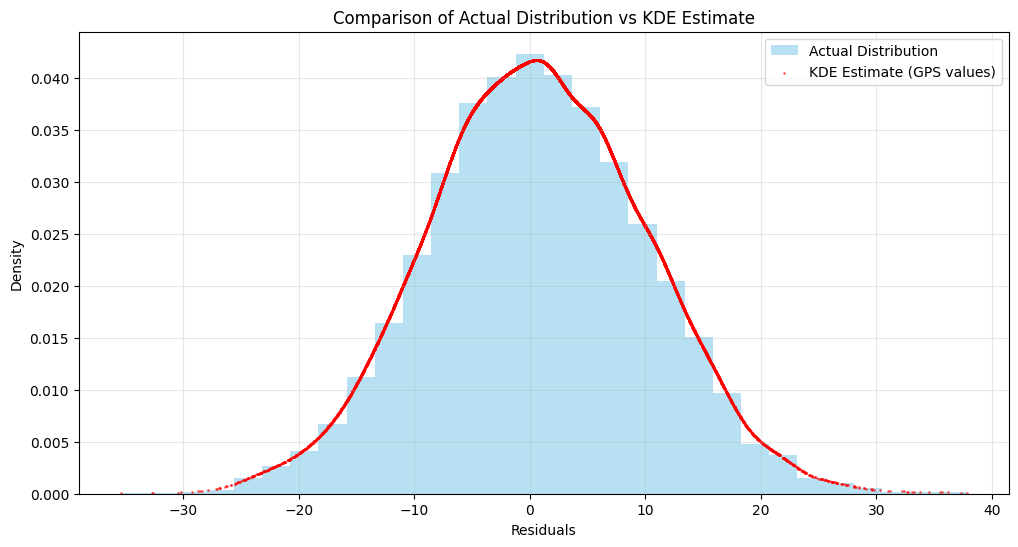

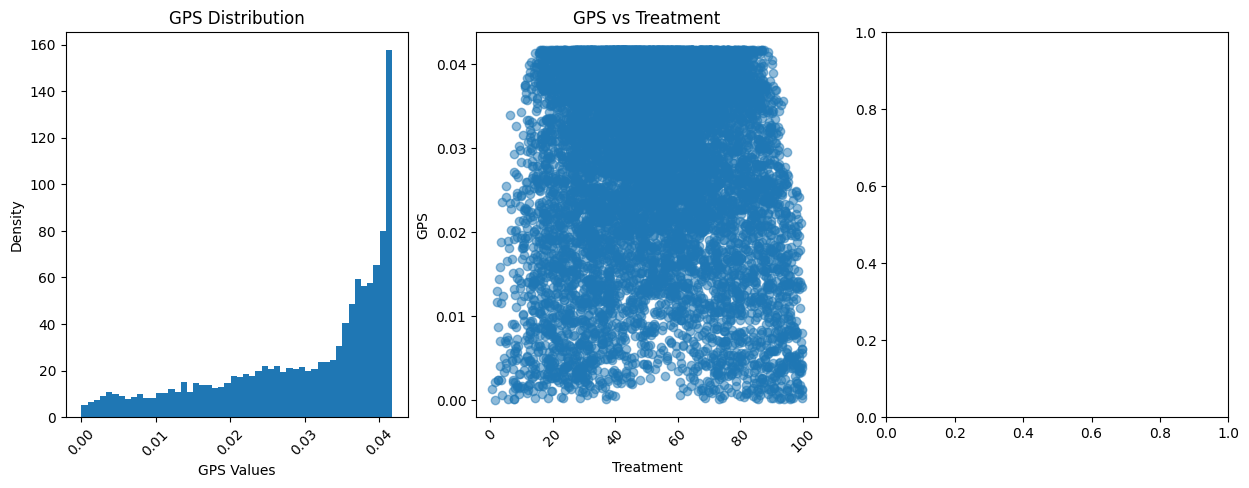

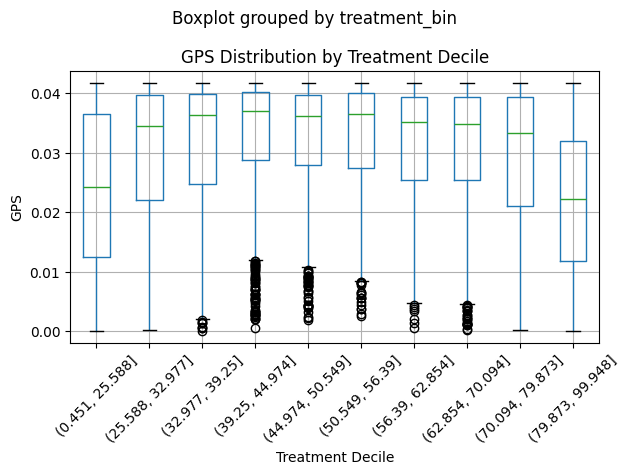

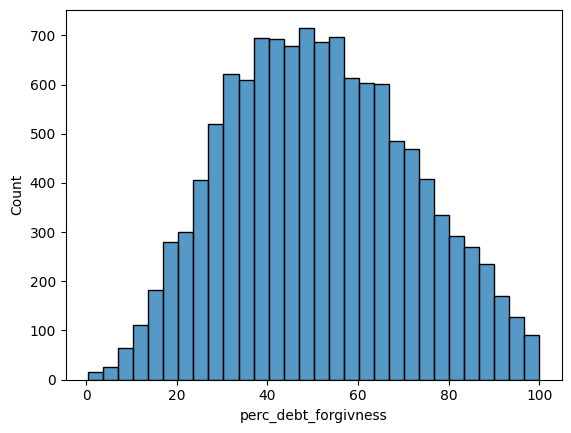

<Figure size 1000x800 with 0 Axes>

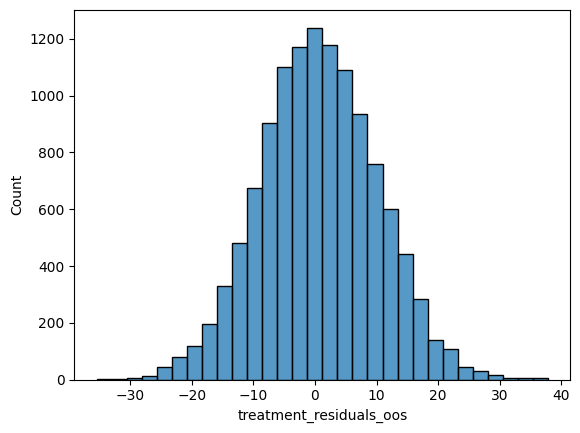

<Figure size 1000x800 with 0 Axes>

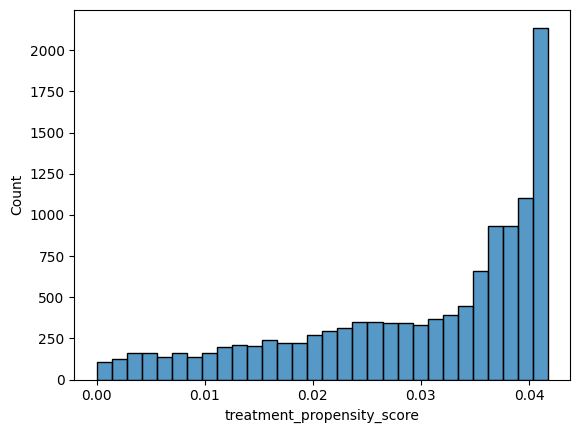

<Figure size 1000x800 with 0 Axes>

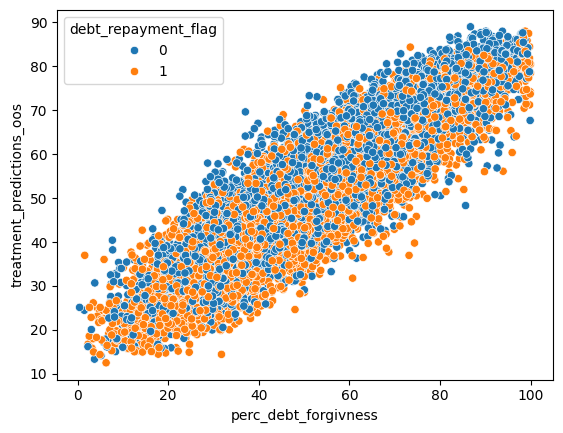

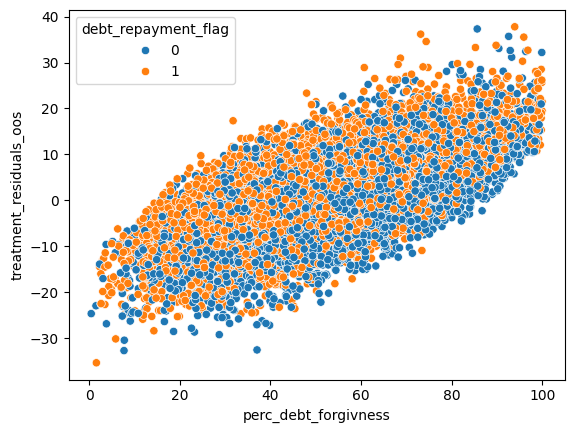

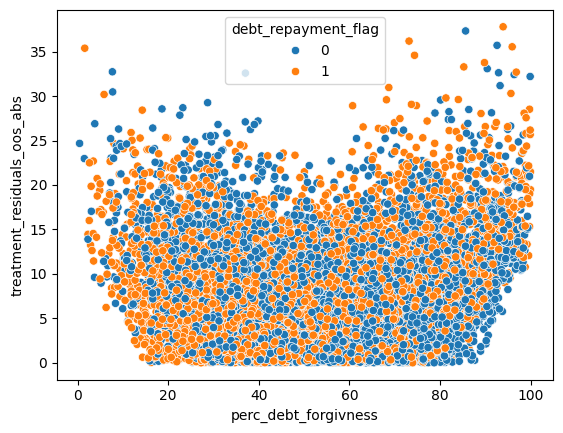

In [12]:
# OOS predictions
if CONTINUOUS_TREATMENT_APPROACH:
    treatment_bins = pd.cut(train[TREATMENT], bins=bin_edges, labels=False,)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_residuals = train.copy()
    train_residuals["treatment_predictions_oos"] = 0.0

    # Perform cross-validation
    for train_idx, test_idx in kf.split(X_train, treatment_bins):
        X_train_fold, X_test_fold = (
            X_train.iloc[train_idx, :], 
            X_train.iloc[test_idx, :]
        )
        t_train_fold, t_test_fold = train.iloc[train_idx, :][[TREATMENT]], train.iloc[test_idx, :][[TREATMENT]]
        sample_weight_fold = create_sample_weights(t_train_fold, bin_edges)

        init_params = {
            "n_estimators": 200,
            "depth": None,
            "min_data_in_leaf": round(X_train_fold.shape[0]*0.01),
            "learning_rate": 0.01,
            "subsample": 1,
            "rsm": 1,
            "objective": "RMSE",
            "silent": True,
            "l2_leaf_reg": 3
        }
        model_t_fold = CatBoostRegressor(**init_params)
        model_t_fold.fit(
            X_train_fold, 
            t_train_fold, 
            sample_weight=sample_weight_fold
        )
        # Predict on test data
        train_residuals.iloc[test_idx, -1] = model_t_fold.predict(X_test_fold)


    # Extract residuaks and residuals variance
    train_residuals["treatment_residuals_oos"] = train_residuals[TREATMENT] - train_residuals["treatment_predictions_oos"] 
    sigma_hat = np.sqrt(np.mean(train_residuals["treatment_residuals_oos"]**2))  # MSE -> sigma^2t)
    print("Models Fitted")

    # get best KDE params
    residuals = train_residuals["treatment_residuals_oos"].to_numpy().reshape(-1, 1)
    treatment_values = np.array(train_residuals[TREATMENT].to_numpy()).flatten()
    best_params = optimize_kde_params(residuals)

    # Fit KDE
    kde = KernelDensity(**best_params)
    kde.fit(residuals)
    gps_values = np.exp(kde.score_samples(residuals))
    train_residuals["treatment_propensity_score"] = gps_values


    print("\nFirst 5 GPS values:\n", gps_values[:5])
    print("\nEstimated RMSE:", sigma_hat)
    print(f"Estimated MAE: {np.mean(train_residuals['treatment_residuals_oos'].abs())}")
    plot_kde_vs_hist(residuals, gps_values, kde)
    plot_gps_diagnostics(treatment_values, gps_values)
    plot_hist(train_residuals, TREATMENT)
    plot_hist(train_residuals, "treatment_residuals_oos")
    plot_hist(train_residuals, "treatment_propensity_score")
    sns.scatterplot(data=train_residuals, x=TREATMENT, y="treatment_predictions_oos", hue=OUTCOME)
    plt.show()
    sns.scatterplot(data=train_residuals, x=TREATMENT, y="treatment_residuals_oos", hue=OUTCOME)
    plt.show()
    train_residuals["treatment_residuals_oos_abs"] = train_residuals["treatment_residuals_oos"].abs()
    sns.scatterplot(data=train_residuals, x=TREATMENT, y="treatment_residuals_oos_abs", hue=OUTCOME)
    plt.show()

In [13]:
# OOS predictions
if MULTICLASS_TREATMENT_APPROACH:

    treatment_bins_equal_width = pd.cut(
        train[TREATMENT], 
        bins=bin_edges,
        include_lowest=False,
        right=True
    )
    train[TREATMENT + "_binned"] = treatment_bins_equal_width
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    all_probs = np.zeros((len(train), len(treatment_bins_equal_width.unique())))

    # Perform cross-validation

    treatment_bins_equal_width_le = LabelEncoder().fit_transform(treatment_bins_equal_width)
    for iter, (train_idx, test_idx) in enumerate(kf.split(X_train, treatment_bins_equal_width_le)):
        print(iter)
        X_train_fold, X_test_fold = (
            X_train.iloc[train_idx, :], 
            X_train.iloc[test_idx, :]
        )
        t_train_fold, t_test_fold = train.iloc[train_idx, :][[TREATMENT + "_binned"]], train.iloc[test_idx, :][[TREATMENT + "_binned"]]

        # Fit model on training data
        init_params = {
            "n_estimators": 200,
            "depth": None,
            "min_data_in_leaf": round(X_train_fold.shape[0]*0.01),
            "learning_rate": 0.01,
            # "subsample": 1,
            "rsm": 1,
            "objective": "MultiClass",
            "silent": True,
            "l2_leaf_reg": 3,
            "auto_class_weights": 'Balanced'
        }
        model_t_fold = CatBoostClassifier(**init_params)
        model_t_fold.fit(
            X_train_fold, 
            t_train_fold, 
        )

        # Predict on test data
        all_probs[test_idx] = model_t_fold.predict_proba(X_test_fold)
    
    model_classes_original = model_t_fold.classes_
    model_classes_sorted =  model_t_fold.classes_
    # model_classes_sorted.sort(key=lambda x: float(x.strip('()[]').split(',')[0]))
    print(model_classes_sorted)
    reorder_indices = [list(model_classes_original).index(c) for c in model_classes_sorted]
    all_probs = all_probs[:, reorder_indices]

## Probability at all treatment levels

In [14]:
if CONTINUOUS_TREATMENT_APPROACH:
    exploded_index_list = explode_list(list(train.index), len(intervals))
    preds = train_residuals["treatment_predictions_oos"].copy().to_list()
    exploded_preds_list = explode_list(preds, len(intervals))
    interventions_table = pd.DataFrame(columns=["treatment_intervals", "prediction", "gps_values", "treatment_assigned"], index=exploded_index_list)
    interventions_table["treatment_assigned"] = train[TREATMENT]
    interventions_table["treatment_intervals"] = intervals * len(list(train.index))
    interventions_table["prediction"] = exploded_preds_list
    interventions_table["gps_values"] = interventions_table.apply(
        lambda row: kernel_gps(row['prediction'], row['treatment_intervals'], kde, 5), axis=1
        )
    interval_probs = create_gps_array(interventions_table)
elif MULTICLASS_TREATMENT_APPROACH:
    interval_probs = all_probs
    interventions_base_table = pd.DataFrame(columns=["treatment_intervals", "gps_values", "treatment_assigned"], index=train.index)
    interventions_base_table["treatment_assigned"] = train[TREATMENT]
    expanded_rows = []
    for idx_position_customer, idx in enumerate(interventions_base_table.index):
        for idx_position_interval, interval in enumerate(intervals):
            new_row = interventions_base_table.loc[idx].copy()
            new_row['treatment_intervals'] = interval
            gps = interval_probs[idx_position_customer][idx_position_interval]
            new_row['gps_values'] = gps
            expanded_rows.append(new_row)
    interventions_table = pd.DataFrame(expanded_rows)


print("\nInterval Edges:", bin_edges)
print("\nProbability of T in each interval (first 5 rows):")
print(interval_probs[:5, :].round(3))

# We can also verify that each row sums to approximately 1
# but here we only covered 5 to 80. If the model assigns minimal probability
#  outside [5, 80], sums should still be near 1.)
row_sums = interval_probs.sum(axis=1)
print("\nSum of probabilities per row (first 5):", row_sums[:5])


Interval Edges: [ -1   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34
  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70
  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100]

Probability of T in each interval (first 5 rows):
[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.001 0.002 0.004 0.006 0.01  0.014 0.021 0.03
  0.04  0.051 0.063 0.073 0.079 0.082 0.083 0.078 0.073 0.065 0.055 0.047
  0.037 0.028 0.019 0.012 0.008 0.005 0.003 0.002 0.001 0.001 0.    0.
  0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.002 0.004
  0.005 0.008 0.012 0.018 0.026 0.036 0.046 0.058 0.07  0.077 0.081 0.083
  0.081 0.075 0.069 0.06  0.051 0.042 0.032 0.023 0.015 0.01  0.007 0.004
  0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0. 

## Get cusomer-ranges that break the positivity assumption

Treatment values where P(T=t|X=x) = 0

In [15]:
def find_samples_by_threshold(interval_probs, row_ids, intervals, threshold, symbol):
    """
    Given:
      - interval_probs: 2D numpy array of shape (n_samples, n_intervals)
      - intervals: list of (a, b) tuples representing intervals, length = n_intervals
      - threshold: float

    Returns:
      A dictionary where each key is the sample index (0-based),
      and the value is a list of intervals that have probability < threshold.
    """
    # Dictionary to store the results
    results = {}

    # Iterate over each sample (row in interval_probs)
    for row_id, i in zip(row_ids, range(interval_probs.shape[0])):
        # Find which intervals are below the threshold
        below_mask = interval_probs[i] < threshold if symbol == "<" else interval_probs[i] >= threshold
        # Get the indices of those intervals
        below_indices = np.where(below_mask)[0]

        if below_indices.size > 0:
            # Map those indices back to the actual interval tuples
            intervals_below = [intervals[j] for j in below_indices]
            # Store in the dictionary
            results[row_id] = intervals_below

    return results


In [16]:
threshold_value = 0.0001
positivity_violations_dict = find_samples_by_threshold(
    interval_probs,
    train.index,
    intervals,
    threshold_value,
    "<"
)

print(len(positivity_violations_dict.keys()))
positivity_violations_dict_corrected = positivity_violations_dict.copy()

12000


In [17]:
# remove errors
print(len(positivity_violations_dict.keys()))
positivity_violations_dict_corrected = positivity_violations_dict.copy()
for row_id, range_list in positivity_violations_dict.items():
    treatment_val = train.loc[row_id, TREATMENT]
    for inf_cut, sup_cut in range_list:
        if (treatment_val > inf_cut) & (treatment_val <= sup_cut):
            del positivity_violations_dict_corrected[row_id]
            continue
print(len(positivity_violations_dict_corrected.keys()))

12000
11999


In [18]:
_, range_analysis = analyze_ranges(positivity_violations_dict_corrected)
print("\nRange Analysis:")
print(range_analysis)


Range Analysis:
           count  percentage
range                       
(-1, 2)     9776        5.22
(2, 4)      9528        5.09
(4, 6)      9045        4.83
(98, 100)   8550        4.57
(6, 8)      8534        4.56
(96, 98)    8064        4.31
(8, 10)     8002        4.28
(94, 96)    7587        4.05
(10, 12)    7493        4.00
(92, 94)    7092        3.79
(12, 14)    6964        3.72
(90, 92)    6589        3.52
(14, 16)    6429        3.44
(88, 90)    6022        3.22
(16, 18)    5898        3.15
(86, 88)    5491        2.93
(18, 20)    5329        2.85
(84, 86)    4964        2.65
(20, 22)    4818        2.57
(82, 84)    4436        2.37
(22, 24)    4330        2.31
(80, 82)    3911        2.09
(24, 26)    3870        2.07
(78, 80)    3397        1.82
(26, 28)    3393        1.81
(28, 30)    2985        1.59
(76, 78)    2874        1.54
(30, 32)    2577        1.38
(74, 76)    2409        1.29
(32, 34)    2225        1.19
(72, 74)    1944        1.04
(34, 36)    1891        1.

In [19]:
idx = 10
row_id = list(positivity_violations_dict_corrected.keys())[idx]
display(train.loc[row_id, :])
print(positivity_violations_dict_corrected[row_id])

perc_debt_forgivness       70.994055
debt_repayment_flag         1.000000
loss_given_default          0.740414
n_loans                     1.000000
debt_cirbe               8036.760067
default_debt_amount     17503.964441
years_since_default         7.140102
n_refin                     1.000000
n_cards                     4.000000
n_accounts                  0.000000
years_history              20.209236
Name: 2200, dtype: float64

[(-1, 2), (2, 4), (4, 6), (6, 8), (8, 10), (10, 12), (12, 14), (14, 16), (16, 18), (18, 20), (20, 22), (22, 24), (24, 26), (26, 28), (28, 30)]


# Domanin Knowledge propagation

In [20]:
train_positivity_v = filter_non_positivity_samples(train, positivity_violations_dict_corrected, False)
X_train_2_propagate = train_positivity_v.drop(columns=[OUTCOME])
y_train_2_propagate = train_positivity_v[[OUTCOME]]

print(X_train_2_propagate.shape)

(11999, 10)


In [21]:
propagator = DomainPropagation(
    outcome=OUTCOME,
    treatment=TREATMENT,
    perc_step_extrapolation=5,
    undersampling_perc_extrapolation=0.9,
    perc_step_interpolation=5,
    interpolation_method="quadratic_interpolation",
    undersampling_perc_interpolation=0.9,
    quadratic_power=2,
    treatment_range=[0, 100],
    stratified_subsampling=False,
    bin_edges=bin_edges,
    positivity_violations_dict=positivity_violations_dict_corrected,
    seed=10,
)
X_train_propagated, y_train_propagated = propagator.transform(X_train_2_propagate, y_train_2_propagate)
print("Propagation done")

# Cast
X_train_propagated["sample_weights"] = X_train_propagated["sample_weights"].astype(float)
X_train_propagated[TREATMENT] = X_train_propagated[TREATMENT].astype(float)
y_train_propagated[OUTCOME] = y_train_propagated[OUTCOME].astype(int)

# Concat
train_propagated = pd.concat([X_train_propagated, y_train_propagated], axis=1)

# Filter ranges
train_propagated = pd.concat([train, train_propagated], axis=0)
train_propagated["sample_weights"].fillna(1, inplace=True)
train_propagated = train_propagated.drop_duplicates()

    
print(train_propagated.shape)
print(train.shape)

Propagation done
(23770, 12)
(12000, 11)


In [22]:
idx = 23
features_display = controls + [TREATMENT, OUTCOME]
key = list(positivity_violations_dict_corrected.keys())[idx]
print(positivity_violations_dict_corrected[key])
display(train.loc[[key], features_display].sort_values(by=TREATMENT).head(15))
train_propagated.loc[[key], features_display+ ["sample_weights"]].sort_values(by=TREATMENT).head(15)

[(-1, 2), (2, 4), (4, 6), (6, 8), (8, 10), (10, 12), (12, 14), (14, 16), (16, 18), (18, 20), (20, 22), (22, 24), (96, 98), (98, 100)]


,loss_given_default,n_loans,debt_cirbe,default_debt_amount,years_since_default,n_refin,n_cards,perc_debt_forgivness,debt_repayment_flag
13437,0.836877,2,9588.770886,39829.970308,1.848799,2,2,62.415075,1


,loss_given_default,n_loans,debt_cirbe,default_debt_amount,years_since_default,n_refin,n_cards,perc_debt_forgivness,debt_repayment_flag,sample_weights
13437,0.836877,2,9588.770886,39829.970308,1.848799,2,2,1.220000,0,0.999618
13437,0.836877,2,9588.770886,39829.970308,1.848799,2,2,62.415075,1,1.000000


In [23]:
# train_propagated.drop(columns=[TREATMENT + "_binned"], inplace=True)
train_propagated.drop(columns=["sample_weights"]).to_parquet("data/synthetic_train_data_propagated.parquet")